# Prioritised screening assignments
This notebook is used to create assignments in the **AI for adaptation in cities** project on NACSOS-nexus   
Project ID: `3d761435-fe4f-4829-a33e-26fc52a46613`

Requirements:
```
pip install -U "nacsos_data[utils,scripts] @ git+ssh://git@gitlab.pik-potsdam.de/mcc-apsis/nacsos/nacsos-data.git@v0.15.5"
pip install -U pandas, torch, evaluate, tqdm, datasets, transformers, matplotlib
```

First, this notebook should be copied and the counter in the filename increased by 1. The notebook is kept in the repository as a log for each assignment scope.

You need to make changes in four places:
* Adjust the assignment scopes and resolutions where labels come from
* Adjust the filename where predictions are saved directly after training/predicting
* Adjust the filename where predictions were saved before running assignments
* Adjust the name, description, and configuration for the new assignment scope
* Adjust the filename where predictions and assignments are saved at the end

In [41]:
import logging
import uuid

import pandas as pd
import numpy as np
from sqlalchemy import select, func, distinct, or_, and_, union, text

from nacsos_data.db import get_engine
from nacsos_data.db.schemas.imports import Import, m2m_import_item_table
from nacsos_data.db.schemas.items.academic import AcademicItem, AcademicItemVariant
from nacsos_data.db.schemas.items.base import Item
from nacsos_data.db.schemas import AnnotationScheme, AssignmentScope, Assignment, Annotation, BotAnnotationMetaData, BotAnnotation
from nacsos_data.util.academic.duplicate import str_to_title_slug

db_engine = get_engine(conf_file='/usr/share/nacsos/server.env')

logging.basicConfig(format='%(asctime)s [%(levelname)s] %(name)s: %(message)s', level=logging.INFO)
logger = logging.getLogger('import')
logger.setLevel(logging.DEBUG)

pd.options.display.max_columns = None

PROJECT_ID = '3d761435-fe4f-4829-a33e-26fc52a46613'
SCHEME_ID = '4658a522-0626-4074-b207-ed46ea13d2a1'

JOSEFINE = '45c63ef0-2af7-4652-b096-cff368497fea'
FELIX = '6f57074c-b145-4826-a20c-2aba8939758f'
LYNN = '8049cefa-6f2a-4fed-8b71-ca9424dd99c6'
NIKOLA = '3cd7dc2a-f920-4699-898e-7760ef7fb063'
FREDA = 'c1a5ad43-348a-40ad-a6f5-96df26022ce4'

## Data helpers
Some of the cells later on require you to specify the imports, annotation scheme, assignment scopes, or resolutions to use as labelled data. The following three cells are helpers to generate these lists.

In [ ]:
with db_engine.session() as session:
    rslt = session.execute(select(AssignmentScope).join(AnnotationScheme).where(AnnotationScheme.project_id == PROJECT_ID).order_by(AssignmentScope.name)).scalars().all()
    for r in rslt:
        print(f"'{r.assignment_scope_id}', -- {r.name}")

In [ ]:
with db_engine.session() as session:
    rslt = session.execute(select(BotAnnotationMetaData).where(BotAnnotationMetaData.project_id == PROJECT_ID).order_by(BotAnnotationMetaData.name)).scalars().all()
    for r in rslt:
        print(f"'{r.bot_annotation_metadata_id}', -- {r.name}")

In [ ]:
with db_engine.session() as session:
    rslt = session.execute(select(Import).where(Import.project_id == PROJECT_ID).order_by(Import.name)).scalars().all()
    for r in rslt:
        print(f"'{r.import_id}': '{r.name}',")

## Data sources
`IMPORTS_ORIG` contains all data from the original dataset,   
`IMPORTS_UPD_PRE` contains all data from the updated queries (published before 2022),   
`IMPORTS_UPD_POST` contains all data from the updated queries (published after 2022).

In [42]:
IMPORTS_ORIG = {
    'dce23cb8-901a-42ef-995d-e2b2dc7ddce3': 'Original data (bikes and scooters)',
    'b5ea5cff-7856-433f-a6ec-2c5510a23293': 'Original data (buildings)',
    '18a17c5f-c96d-4fa4-b0a1-a639193ea1f7': 'Original data (transport)',
    'beb43723-d07a-4224-999e-d4e50f5b0744': 'Original data (urban form)',
    '13ef9fb4-8d10-4a1e-b35d-3c8b7d6f4ad3': 'Original data (waste)',
}

IMPORTS_UPD_PRE = {
    '22c15f11-eaa2-486a-9812-e6520fe75e22': 'Updated Query (11.07.2024) | < 2022 | Bikes',
    '83aa7428-945f-4e4a-b368-350e549d5e40': 'Updated Query (11.07.2024) | < 2022 | Buildings',
    'ceb6a7b1-353b-451e-a56b-bda86a543bd0': 'Updated Query (11.07.2024) | < 2022 | Transport',
    'ef69e746-2f64-4cb2-86d0-c3b4154531e9': 'Updated Query (11.07.2024) | < 2022 | Urban form',
    '06547d84-8f9a-4b22-993d-e1cbf7e6b54e': 'Updated Query (11.07.2024) | < 2022 | Waste',
}
IMPORTS_UPD_POST = {
    '9b656ac6-bc73-43fa-ab75-2970c4c138f2': 'Updated Query (11.07.2024) | >= 2022 | Waste',
    '8998c855-3d5b-45de-a53b-b6e1c94859b5': 'Updated Query (11.07.2024) | >= 2022 | Urban form',
    '28f2f944-83b3-4cca-8d32-9066736ae8b0': 'Updated Query (11.07.2024) | >= 2022 | Transport',
    '347c4fd1-70ba-49b1-b174-2251bd672070': 'Updated Query (11.07.2024) | >= 2022 | Buildings',
    '10046573-819c-4fb5-8aa1-3d92ab682701': 'Updated Query (11.07.2024) | >= 2022 | Bikes',
}

IMPORTS_UPD = IMPORTS_UPD_PRE | IMPORTS_UPD_POST
IMPORTS = IMPORTS_ORIG | IMPORTS_UPD_PRE | IMPORTS_UPD_POST

## Data preparation
The following cells fetch all the data from the database.

You may need to adjust the list of assignment scopes (in `ass.assignment_scope_id::text = ANY (array [...])`) for all labels that were not resolved yet (using "majority vote" of double-codings). Also, you may need to adjust the list of resolved labels (in `a.bot_annotation_metadata_id::text = ANY (array [...])`).    
Scopes that were resolved should not appear in the list of `assignment_scope_id`s, but only in the list of `bot_annotation_metadata_id`s!

This query usually takes ~20-60s to finish.

In [4]:
stmt = text('''
WITH labels_flat as (SELECT i.item_id, json_build_object(ba.key, ba.value_int) as label
                     FROM item i
                              JOIN bot_annotation ba ON ba.item_id = i.item_id
                     WHERE i.project_id = '3d761435-fe4f-4829-a33e-26fc52a46613'
                       AND ba.key = ANY (array [
                         'incl','cluster',
                         'imp_build', 'imp_trans', 'imp_uf', 'imp_waste', 'imp_meta'
                         ])
                       AND ba.bot_annotation_metadata_id::text = ANY (array [
                        'be1361b6-35ed-4509-bc2a-da10c9d83e91', -- Resolution for "bikes and scooters"
                        'c42b71c7-f1dc-46b2-b187-72fa78f8a397', -- Resolution for "buildings"
                        'c77b8462-7ab5-4bac-b686-6008c8fbe727', -- Resolution for "transport"
                        '0057dc42-5821-445b-b3d5-834d0958d110', -- Resolution for "urban form"
                        'b386ae78-ae35-428a-be34-abceab9dba3f', -- Resolution for "Waste"
                        '18ce3c5c-116a-41ce-a343-4fe7964f3c2e', -- Resolved_20240715_prioritised_bikes_JH_NM_done
                        'a122bbe1-610c-4f09-91fe-bec96e921a42', -- Resolved_20240715_prioritised_build_JH_NM
                        'bd76251c-902d-4f80-bd5a-4a8a86bac673', -- Resolved_20240715_prioritised_trans_JH_NM
                        'ead682c1-a2bf-44d2-9ec6-1f2243b17449', -- Resolved_20240715_prioritised_urban_JH_NM
                        'b2152ad1-09a1-492b-a0d1-9c6176854ca8', -- Resolved_20240715_prioritised_waste_JH_NM
                        '2d99ac7f-0bef-4a24-8fde-f210a8c549a4' -- Resolved_20240717_prioritised_waste_JH_NM_FP
                         ])),
     labels as (SELECT item_id, json_agg(label) as labels
                FROM labels_flat
                GROUP BY item_id),
     ulabels_flat as (SELECT i.item_id, json_build_object(a.key, a.value_int) as label
                      FROM item i
                               JOIN annotation a ON a.item_id = i.item_id
                               JOIN assignment ass ON a.assignment_id = ass.assignment_id
                      WHERE i.project_id = '3d761435-fe4f-4829-a33e-26fc52a46613'
                        AND a.key = ANY (array [
                          'incl','cluster',
                          'imp_build', 'imp_trans', 'imp_uf', 'imp_waste', 'imp_meta'
                          ])
                        AND ass.assignment_scope_id::text = ANY (array [
                        '8fc1f9b3-7ed1-4af1-a2d9-8d1744827dac', -- 20240715_prioritised_bikes_JH_NM_FC
                        '00afa75f-4e1f-49db-b6d3-8a98ad2138c3', -- 20240715_prioritised_build_JH_NM_FC
                        '145c4809-3d18-482a-81f3-a55ace81ace4', -- 20240715_prioritised_trans_JH_NM_FC
                        'bbac2f15-ac3d-4ff0-b054-291a7c117a26', -- 20240715_prioritised_urban_JH_NM_FC
                        '27ed2842-0e23-4bae-88ae-f8b170f80ecc', -- 20240715_prioritised_waste_JH_NM_FC
                        'c812842c-8e1c-45ba-a8aa-7c26e31066b0', -- 20240717_prioritised_bikes_JH_NM_FP
                        'f8e62b5d-4b1e-4266-90e8-8475e3fcc70f', -- 20240717_prioritised_build_JH_NM_FP
                        'ce2dcbd3-5b98-4505-920c-ae0857c5a186', -- 20240717_prioritised_trans_JH_NM_FP
                        'c15d03ce-3b00-4169-bd1a-58cef9772d72', -- 20240717_prioritised_urban_JH_NM_FP
                        'b0c734f7-8f27-4d7c-a78c-b7b8f57a3745', -- 20240717_prioritised_waste_JH_NM_FP
                        '3ce421d9-ccb5-4350-9c26-1b43235b4af8', -- 20240718_prioritised_bikes_JH_NM
                        'cc836405-0a1e-431b-a6ab-53790a0f2f18', -- 20240718_prioritised_build_JH_NM
                        '0fd7fba7-2d4d-424e-abc7-4331c40e31b5', -- 20240718_prioritised_trans_JH_NM
                        '76105c1b-9856-49b4-b6c4-d02df0e5b09b' -- 20240718_prioritised_urban_JH_NM
                          ])),
     ulabels as (SELECT item_id, json_agg(label) as labels
                FROM ulabels_flat
                GROUP BY item_id),
     imports as (SELECT item_id, array_agg(DISTINCT import_id) as imports
                 FROM m2m_import_item mii
                 GROUP BY item_id)
SELECT i.item_id,
       i.text              as abstract,
       ai.title,
       ai.publication_year as py,
       ai.wos_id,
       ai.doi,
       labels.labels,
       ulabels.labels as user_labels,
       imports.imports
FROM item i
         JOIN academic_item ai on i.item_id = ai.item_id
         LEFT OUTER JOIN labels ON i.item_id = labels.item_id
         LEFT OUTER JOIN ulabels ON i.item_id = ulabels.item_id
         LEFT OUTER JOIN imports ON i.item_id = imports.item_id
WHERE i.project_id = '3d761435-fe4f-4829-a33e-26fc52a46613';
''')

with db_engine.session() as session:
    rslt = session.execute(stmt).mappings().all()

We'd like to transform the data we retrieved from the database a little more and construct a dataframe in the following cell.

In [5]:
IMPACT_KEYS = ['imp_build', 'imp_trans', 'imp_uf', 'imp_waste', 'imp_meta']
IMPACTS = [{'name': 'Appliance efficiency', 'hint': 'Appliances that can perform a given task needed less energy.', 'value': 0}, {'name': 'Building-level energy consumption', 'hint': 'Focus on overall emissions of building and the reduction thereof, focus on mapping/understanding where high consumption settings are as opposed to actively trying to reduce known high consumption settings.', 'value': 1}, {'name': 'Building retrofit envelope', 'hint': 'Retrofit approach with added insulation and an air barrier around existing walls to improve thermal comfort and reduce drafts.', 'value': 2}, {'name': 'Consumer behavior', 'hint': 'Emission reduction due to changed consumption behavior of residents, linked to appliance efficiency and fuel switch.', 'value': 3}, {'name': 'Demand response', 'hint': 'Change in electricity consumption by end-user(s) (technologies) to help balance the electricity grid or benefit from periods of high availability of renewable energy.', 'value': 4}, {'name': 'District heating and cooling', 'hint': 'Grouped supply for heating and/or cooling for several (typically residential or commercial) buildings, leading to a more energy-efficient supply.', 'value': 5}, {'name': 'Fuel switch', 'hint': 'Changing the type of energy, electricity, and gas, fueling the building  operations e.g. from fossil fuel to renewables.', 'value': 6}, {'name': 'New efficient buildings', 'hint': 'Energy efficient construction and operation as a requirement of newly built stock e.g. via standards.', 'value': 7}, {'name': 'Operational efficiency', 'hint': 'Use of technology that can perform a given task needs less energy e.g. HVAC or lighting.', 'value': 8}, {'name': 'Alternative fuels and infrastructure', 'hint': 'Switching to bio-based fuels and establishing respective distribution and charging infrastructure.', 'value': 9}, {'name': 'Autonomous vehicles', 'hint': 'A vehicle capable of sensing its environment and operating without human involvement.', 'value': 10}, {'name': 'Battery-electrified transport', 'hint': 'Enabling or supporting the use of electric vehicles, public and non-public transport.', 'value': 11}, {'name': 'Charging infrastructure', 'hint': 'Putting in place charging points, linked to convenient parking, matching the demand.', 'value': 12}, {'name': 'Consumer behavior', 'hint': 'Impact based on the choices made by users over mode of transport, distance, and number of trips.', 'value': 13}, {'name': 'Freight operations and routing', 'hint': 'Trips for logistics and delivery of goods, can include policies around speed, parking, and allowed hours.', 'value': 14}, {'name': 'Micromobility', 'hint': 'Range of small, lightweight vehicles operating at low speeds.', 'value': 15}, {'name': 'Pedestrian-cyclist interaction', 'hint': "Includes dynamics between pedestrian flow and cyclists' routes.", 'value': 16}, {'name': 'Not pooled shared mobility', 'hint': 'Vehicle sharing over time, personal rental, no private ownership, shared costs.', 'value': 17}, {'name': 'Pooled shared mobility', 'hint': 'Simultaneous ride-sharing, cost sharing.', 'value': 18}, {'name': 'Public transport O & M', 'hint': 'Changes to operation and maintenance within the existing network.', 'value': 19}, {'name': 'Public transport planning', 'hint': 'Includes conceptualization, ideation, analysis, and design of interventions on existing routes, creation of new routes, and mobility options. Buses, metro, train, trams.', 'value': 20}, {'name': 'Roadway electrification', 'hint': 'Building roads that supply electric power to vehicles e.g. trucks travelling on it.', 'value': 21}, {'name': 'Shared bikes and scooters', 'hint': 'Network of bikes and scooters that can be rented for a period of time by users who pay only for the duration of use.', 'value': 22}, {'name': 'Traffic management and routing', 'hint': 'Optimisation of traffic flow, identification of patterns to improve routing, can include traffic light rhythm.', 'value': 23}, {'name': 'Utility vehicle fleets', 'hint': 'Vehicles for specific tasks such as waste trucks, street cleaning vehicles, maintenance operations, and snow trucks.', 'value': 24}, {'name': 'Vehicle efficiency', 'hint': 'Improvements in driving cycles and fuel consumption.', 'value': 25}, {'name': 'Spatial configuration and transport energy consumption', 'hint': 'Dependencies between spatial configurations and transport energy consumption.', 'value': 26}, {'name': 'Urban & neighborhood design', 'hint': 'Includes place-making, master planning, and interventions based on the design process.', 'value': 27}, {'name': 'Utility infrastructure planning', 'hint': 'System-level conceptualization/ configuration of water and energy grids and other resource flows.', 'value': 28}, {'name': 'Zoning, land use, green space', 'hint': 'Specifications around the type of activities allowed or intended e.g. industrial, residential, mixed-use. often based on local plans or planning policies. zoning is common in the USA.', 'value': 29}, {'name': 'Street network design', 'hint': 'Process to determine hierarchies between streets, linkages, and crossings. Both at the neighborhood and city levels.', 'value': 30}, {'name': 'CO2 emission & energy consumption prediction', 'hint': 'Mapping CO2 emissions in cities across sectors and linking their values to urban form characteristics.', 'value': 31}, {'name': 'Multi-city comparison', 'hint': 'Comparative studies involving different urban contexts, in the same or different countries.', 'value': 32}, {'name': 'Street lighting', 'hint': 'Agile management and increased efficiency of public lighting  infrastructure.', 'value': 33}, {'name': 'Circular economy', 'hint': 'Processes to convert waste to resource, to divert waste from landfill, include recycling, and composting with clear climate mitigation relevance.', 'value': 34}, {'name': 'Municipal solid waste management', 'hint': 'Management of processing waste types consisting of everyday items that are discarded by the public, including collection and transport of waste to the place of treatment or discharge by municipal services.', 'value': 35}, {'name': 'Waste to energy', 'hint': 'Waste treatment processes that creates energy in the form of electricity, heat or transport fuels, biomass gasification.', 'value': 36}, {'name': 'Wastewater management', 'hint': 'Generation of the polluted form of water ie. sewage (rainfall and human activities), treatment as the process used to remove contaminants from wastewater and convert it into an effluent that can be returned to the water cycle.', 'value': 37}, {'name': 'Food loss and waste', 'hint': 'A decrease at all stages of the food system from production to consumption, in mass and/or quality, of food that was originally intended for human consumption, regardless of the cause.', 'value': 38}, {'name': 'Landfill methane emission prediction', 'hint': 'Forecasting amount of methane gas as a natural byproduct of the decomposition of organic material in landfills.', 'value': 39}, {'name': 'Modeling method contribution', 'hint': 'Focus on creating or advancing an ML method in accuracy or calculation pace.', 'value': 40}, {'name': 'Dataset provision & Data imputation', 'hint': 'Using ML for data acquisition and substitution.', 'value': 41}, {'name': 'Multi-stakeholder planning process', 'hint': 'Integration of different stakeholder groups like citizens, private or public sector.', 'value': 42}]
CLUSTERS = [{'name': 'Buildings', 'value': 0}, {'name': 'Transport', 'value': 1}, {'name': 'Urban form', 'value': 2}, {'name': 'Waste', 'value': 3}, {'name': 'Meta-characteristics', 'value': 4}]

data = [{
        'item_id': str(r['item_id']),
        'title': r['title'],
        'abstract': r['abstract'],
        'text': f"{r['title']} {r['abstract']}",
        'wos_id': r['wos_id'],
        'doi': r['doi'],
        'py': r['py'],
        'labels': r['labels'],
        'user_labels': r['user_labels'],
        'imports': [str(ri) for ri in r['imports']],
        **{
            IMPORTS[str(im)]: True
            for im in r['imports']
            if str(im) in IMPORTS
        },
    # Resolved labels
        **{
            k if k not in IMPACT_KEYS else 'impact': v
            for li in (r['labels'] or [])
            for k, v in li.items()
        },
        **{
            f'impact|{v}': True
            for li in (r['labels'] or [])
            for k, v in li.items()
            if k in IMPACT_KEYS
        },
        **{
            f'cluster|{v}': True
            for li in (r['labels'] or [])
            for k, v in li.items()
            if k == 'cluster'
        },
    # Unresolved labels
        **{
            k if k not in IMPACT_KEYS else 'impact': v
            for li in (r['user_labels'] or [])
            for k, v in li.items()
        },
        **{
            f'impact|{v}': True
            for li in (r['user_labels'] or [])
            for k, v in li.items()
            if k in IMPACT_KEYS
        },
        **{
            f'cluster|{v}': True
            for li in (r['user_labels'] or [])
            for k, v in li.items()
            if k == 'cluster'
        }
    } for r in rslt]

df = pd.DataFrame(data)    
df['incl'] = df['incl'].astype('Int8')
df['cluster'] = df['cluster'].astype('Int8')
df['impact'] = df['impact'].astype('Int8')
df['py'] = df['py'].astype('Int16')
df = df.replace({np.nan: None})

def oring(arr):
    ret = arr[0]
    for a in arr[1:]:
        ret |= a
    return ret

def anding(arr):
    ret = arr[0]
    for a in arr[1:]:
        ret &= a
    return ret

df['import_orig'] = oring([df[k].astype(bool) for k in IMPORTS_ORIG.values()])
df['import_upd'] = oring([df[k].astype(bool) for k in IMPORTS_UPD.values()])
df['import_upd_pre'] = oring([df[k].astype(bool) for k in IMPORTS_UPD_PRE.values()])
df['import_upd_post'] = oring([df[k].astype(bool) for k in IMPORTS_UPD_POST.values()])

mask_seen = (~df['labels'].isna() | ~df['user_labels'].isna())
mask_unseen = ~mask_seen

print('Shape:', df.shape)
print(f'Seen: {mask_seen.sum():,} | unseen: {mask_unseen.sum():,}')
print(f'Updated import: {df['import_upd'].sum():,} | '
      f'old import: {df['import_orig'].sum():,} | '
      f'overlap: {(df['import_upd'] & df['import_orig']).sum():,}')
print(f'old and seen: {(df['import_orig'] & mask_seen).sum():,} | '
      f'new and seen: {(df['import_upd'] & mask_seen).sum():,}')
print(f'old and unseen: {(df['import_orig'] & mask_unseen).sum():,} | '
      f'new and unseen: {(df['import_upd'] & mask_unseen).sum():,}')
df.head()

Shape: (6521, 79)
Seen: 3,518 | unseen: 3,003
Updated import: 5,528 | old import: 2,908 | overlap: 2,178
old and seen: 2,823 | new and seen: 2,798
old and unseen: 85 | new and unseen: 2,730


item_id  \
0  00042c95-05f2-4265-94da-0b798e68ef67   
1  002103df-3522-401e-b8cf-37c3f8de08b9   
2  0025bae6-5100-49ec-b4e9-8e7ad5c59233   
3  003ec709-1f1a-4459-9023-49471df2b8a6   
4  005411f3-84cf-4da9-8678-2e92de53c052   

                                               title  \
0  DISCRIMINANT ANALYSIS REGULARIZATION IN LIGHTW...   
1  Computer Vision classifier and platform for au...   
2  A New Method for Traffic Participant Recogniti...   
3  Many-Objective Optimization Design of a Public...   
4  The Nutrient Status of Plant Roots Reveals Com...   

                                            abstract  \
0  In this paper, we first propose lightweight de...   
1  Data on urban mobility is traditionally obtain...   
2  The latest survey results show an increase in ...   
3  The energy performance of buildings especially...   
4  Controversial competition theories may confuse...   

                                                text               wos_id  \
0  DISCRIMINANT ANALYSIS REGULARIZATION IN LIGHTW...                 None   
1  Computer Vision classifier and platform for au...                 None   
2  A New Method for Traffic Participant Recogniti...  WOS:001256471000001   
3  Many-Objective Optimization Design of a Public...                 None   
4  The Nutrient Status of Plant Roots Reveals Com...                 None   

                   doi    py                                           labels  \
0                 None  2019                                    [{'incl': 0}]   
1                 None  2017                                    [{'incl': 0}]   
2    10.3390/s24123832  2024                                             None   
3  10.3390/app10072435  2020  [{'imp_build': 8}, {'incl': 1}, {'cluster': 0}]   
4    10.3390/f11111163  2020                                    [{'incl': 0}]   

  user_labels                                 imports  \
0        None  [dce23cb8-901a-42ef-995d-e2b2dc7ddce3]   
1        None  [dce23cb8-901a-42ef-995d-e2b2dc7ddce3]   
2        None  [10046573-819c-4fb5-8aa1-3d92ab682701]   
3        None  [b5ea5cff-7856-433f-a6ec-2c5510a23293]   
4        None  [dce23cb8-901a-42ef-995d-e2b2dc7ddce3]   

  Original data (bikes and scooters)  incl  \
0                               True     0   
1                               True     0   
2                               None  None   
3                               None     1   
4                               True     0   

  Updated Query (11.07.2024) | >= 2022 | Bikes Original data (buildings)  \
0                                         None                      None   
1                                         None                      None   
2                                         True                      None   
3                                         None                      True   
4                                         None                      None   

  impact cluster impact|8 cluster|0  \
0   None    None     None      None   
1   None    None     None      None   
2   None    None     None      None   
3      8       0     True      True   
4   None    None     None      None   

  Updated Query (11.07.2024) | < 2022 | Bikes  \
0                                        None   
1                                        None   
2                                        None   
3                                        None   
4                                        None   

  Updated Query (11.07.2024) | < 2022 | Buildings  \
0                                            None   
1                                            None   
2                                            None   
3                                            None   
4                                            None   

  Updated Query (11.07.2024) | < 2022 | Transport  \
0                                            None   
1                                            None   
2                                            None   
3          

Check the number of inclusion/exclusion labels:

In [6]:
df['incl'].value_counts()

incl
1    1794
0    1724
Name: count, dtype: int64

## Training and prediction
This following cell trains a climatebert transformer. The settings usually work fine. Training for more epochs has lead to overfitting, 2 epochs is probably also fine.

After the model is trained, it will predict on *all* data.

In [8]:
import torch
import evaluate
from tqdm import tqdm
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoModelForMaskedLM


def compute_metrics(p):
    logits, labels = p
    predictions = np.argmax(logits, axis=-1)
    return {
        'recall': evaluate.load('recall').compute(predictions=predictions, references=labels, zero_division=0, average='weighted')['recall'],
        'precision': evaluate.load('precision').compute(predictions=predictions, references=labels, zero_division=0, average='weighted')['precision'],
        'f1': evaluate.load('f1').compute(predictions=predictions, references=labels, labels=np.arange(len(labels)), average='weighted')['f1'],
        'accuracy': evaluate.load('accuracy').compute(predictions=predictions, references=labels, normalize=False)['accuracy']
    }

dfi = df[~df['incl'].isna()][['text', 'incl']].copy()
dfi['label'] = dfi['incl']
labels = ['Exclude', 'Include']
lnames = ['Exclude', 'Include']
pcols = ['pred_incl|0', 'pred_incl|1']
pcol = 'pred_incl'

model_name = 'climatebert/distilroberta-base-climate-f'
tokenizer = AutoTokenizer.from_pretrained(model_name, max_length=512, model_max_length=512)

BATCH_SIZE_PRED = 50

df_train = dfi.sample(frac=0.8)
mask_train = dfi.index.isin(df_train.index)
mask_test = ~mask_train

df_test = dfi[mask_test]
labels = list(dfi['label'].unique())

print('labels', labels)
print('columns', pcols)
print('mask train', mask_train.sum(), 'test', mask_test.sum())
print('df train', df_train.shape, 'test', df_test.shape)
print()
print('train')
print(df_train['label'].value_counts())
print('test')
print(df_test['label'].value_counts())

train_dataset = Dataset.from_pandas(df_train)
train_dataset = train_dataset.map(lambda rows: tokenizer(rows['text'], padding='max_length', truncation=True), batched=True)

eval_dataset = Dataset.from_pandas(df_test)
eval_dataset = eval_dataset.map(lambda rows: tokenizer(rows['text'], padding='max_length', truncation=True), batched=True)

print(len(train_dataset), len(eval_dataset))

print('Loading model...')
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(labels))

# Define training arguments
training_args = TrainingArguments(
    output_dir='data/results',
    logging_dir='data/logs',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=50,
    warmup_steps=400,
    weight_decay=0.01,
    logging_steps=10,
    eval_strategy='steps',
    eval_steps=50,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
print('Training model...')
trainer.train()

print('Predicting...')
preds = []
with torch.no_grad():
    ds = Dataset.from_pandas(df)
    ds = ds.map(lambda x: tokenizer(x['text'], padding='max_length', truncation=True), batched=True)
    ds.set_format('torch')

    for batch in tqdm(ds.iter(batch_size=BATCH_SIZE_PRED)):
        pred = model(input_ids=batch['input_ids'].to('cuda'), attention_mask=batch['attention_mask'].to('cuda'))
        preds.append(torch.softmax(pred.logits, dim=1).cpu())

preds = torch.concatenate(preds)

labels [0, 1]
columns ['pred_incl|0', 'pred_incl|1']
mask train 2814 test 704
df train (2814, 3) test (704, 3)

train
label
1    1428
0    1386
Name: count, dtype: int64
test
label
1    366
0    338
Name: count, dtype: int64


Map:   0%|          | 0/2814 [00:00<?, ? examples/s]

Map:   0%|          | 0/704 [00:00<?, ? examples/s]

2814 704
Loading model...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at climatebert/distilroberta-base-climate-f and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[codecarbon INFO @ 15:02:27] [setup] RAM Tracking...
[codecarbon INFO @ 15:02:27] [setup] GPU Tracking...
[codecarbon INFO @ 15:02:27] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 15:02:27] [setup] CPU Tracking...
[codecarbon WARNING @ 15:02:27] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 15:02:28] We saw that you have a AMD Ryzen 7 5700X 8-Core Processor but we don't know it. Please contact us.
[codecarbon INFO @ 15:02:28] CPU Model on constant consumption mode: AMD Ryzen 7 5700X 8-Core Processor
[codecarbon INFO @ 15:02:28] >>> Tracker's metadata:
[codecarb

Training model...


[codecarbon INFO @ 15:02:46] Energy consumed for RAM : 0.000098 kWh. RAM Power : 23.512254238128662 W
[codecarbon INFO @ 15:02:46] Energy consumed for all GPUs : 0.000611 kWh. Total GPU Power : 146.67390625632527 W
[codecarbon INFO @ 15:02:46] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:02:46] 0.000886 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:03:01] Energy consumed for RAM : 0.000196 kWh. RAM Power : 23.512254238128662 W
[codecarbon INFO @ 15:03:01] Energy consumed for all GPUs : 0.001225 kWh. Total GPU Power : 147.42668990731303 W
[codecarbon INFO @ 15:03:01] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:03:01] 0.001776 kWh of electricity used since the beginning.
/home/rept/.venvs/main12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted sample

Predicting...


Map:   0%|          | 0/6521 [00:00<?, ? examples/s]

131it [01:09,  1.89it/s]


### Saving results
We'd like to remember all our predictions for later. The following cell adds the model scores to the dataframe and marks which data was used for training and testing.

**Adjust** the filename (typically increase counter by 1)

In [9]:
df[pcol] = preds.argmax(dim=1)
for li, c in enumerate(pcols):
    df[c] = preds[:,li]

df.loc[df_train.index, 'train'] = 1
df.loc[df_test.index, 'test'] = 1

df.to_feather(f'data/screening_round_04.arrow')

## Evaluation
The following cells can simply be executed one by one. It is typically a good idea to check the numbers and verify they are within the expected range. Otherwise, this is mainly for logging.

In [10]:
labels

[0, 1]

In [11]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, classification_report
from matplotlib import pyplot as plt

y_true = df[df['test']==1]['incl'].to_numpy().astype(int)
y_pred = df[df['test']==1][pcols].to_numpy()
    
print(classification_report(y_true, y_pred.argmax(axis=1), target_names=lnames))

              precision    recall  f1-score   support

     Exclude       0.84      0.85      0.85       338
     Include       0.86      0.85      0.86       366

    accuracy                           0.85       704
   macro avg       0.85      0.85      0.85       704
weighted avg       0.85      0.85      0.85       704



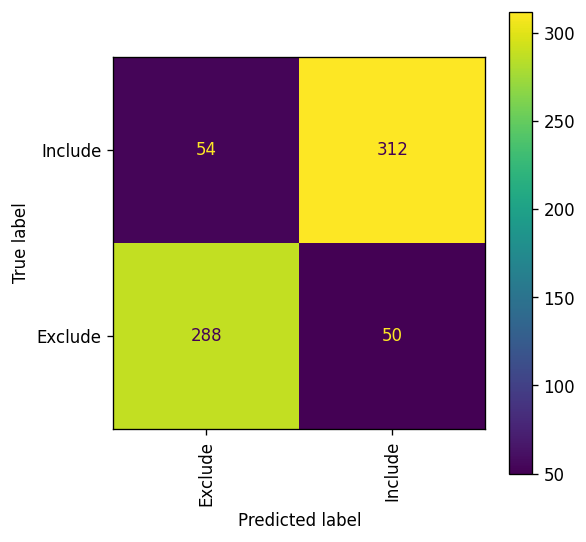

In [12]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=120)
#ax.set_title(col)
ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred.argmax(axis=1),
    labels=list(range(len(lnames))),
    display_labels=lnames,
    xticks_rotation='vertical',
    ax=ax
)
ax.invert_yaxis()
fig.show()

/home/rept/.venvs/main12/lib/python3.12/site-packages/sklearn/metrics/_plot/roc_curve.py:171: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


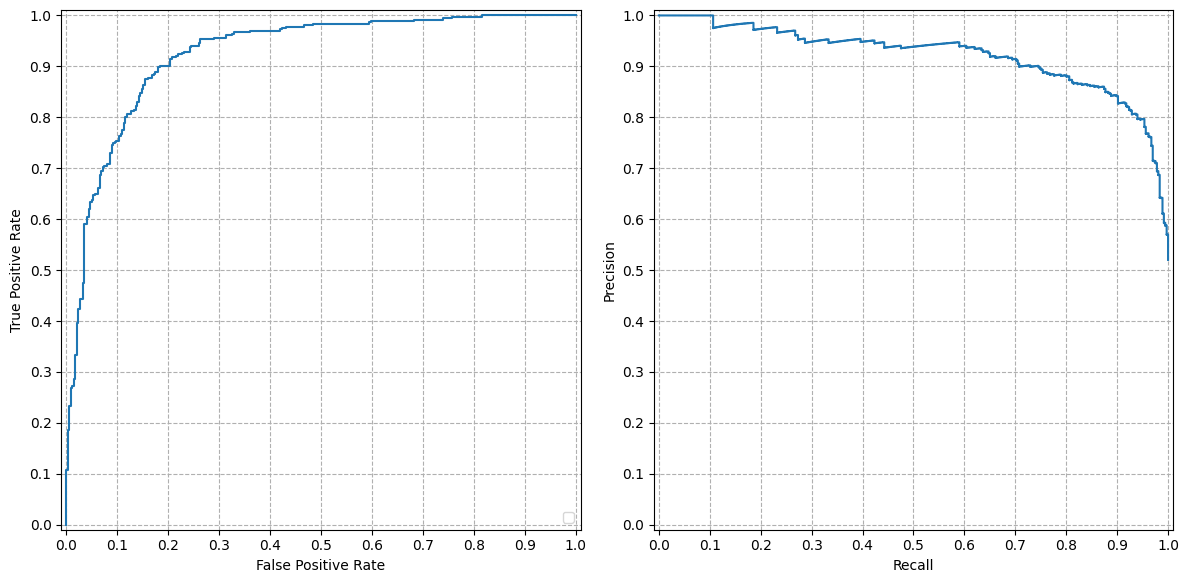

In [13]:
from matplotlib import pyplot as plt
from sklearn.metrics import RocCurveDisplay, roc_curve, precision_recall_curve, PrecisionRecallDisplay

y_true = df[df['test']==1]['incl'].to_numpy().astype(int)
y_scores = df[df['test']==1]['pred_incl|1'].to_numpy()

fpr, tpr, _ = roc_curve(y_true, y_scores)
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall)

roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
ax1.set_xticks(np.arange(0, 1.1, 0.1))
ax1.set_yticks(np.arange(0, 1.1, 0.1))
ax1.grid(visible=True, linestyle='--')
ax2.set_xticks(np.arange(0, 1.1, 0.1))
ax2.set_yticks(np.arange(0, 1.1, 0.1))
ax2.grid(visible=True, linestyle='--')
fig.tight_layout()
plt.show()

Text(0.5, 1.0, 'Histogram of classifier scores in test set')

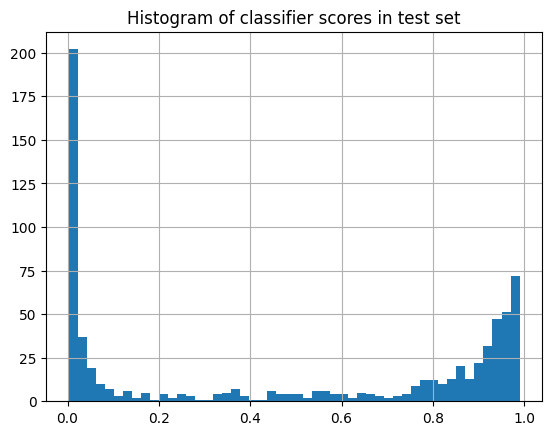

In [14]:
ax = df[df['test']==1]['pred_incl|1'].hist(bins=50)
ax.set_title('Histogram of classifier scores in test set')

### Workload estimation
We'd like to know how much we ne need to annotate. Here, we compute rough estimations based on results from the latest classifier.

In [17]:
pd.DataFrame({'precision': precision, 'recall': recall, 'threshold': thresholds.tolist()+[1]}).T

0         1         2         3         4         5    \
precision  0.519886  0.520626  0.521368  0.522111  0.522857  0.523605   
recall     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
threshold  0.002372  0.002432  0.002571  0.002593  0.002685  0.002723   

                6         7         8         9         10        11   \
precision  0.524355  0.525108  0.525862  0.526619  0.527378  0.528139   
recall     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
threshold  0.002738  0.002780  0.002808  0.002857  0.002927  0.002980   

                12        13        14        15        16        17   \
precision  0.528902  0.529667  0.530435  0.531205  0.531977  0.532751   
recall     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
threshold  0.003003  0.003045  0.003119  0.003217  0.003309  0.003347   

                18        19        20        21        22        23   \
precision  0.533528  0.534307  0.535088  0.535871  0.536657  0.537445   
recall     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
threshold  0.003348  0.003398  0.003413  0.003423  0.003463  0.003481   

                24        25        26        27        28        29   \
precision  0.538235  0.539028  0.539823  0.540620  0.541420  0.542222   
recall     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
threshold  0.003483  0.003502  0.003520  0.003522  0.003536  0.003550   

                30        31        32        33        34        35   \
precision  0.543027  0.543834  0.544643  0.545455  0.546269  0.547085   
recall     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
threshold  0.003555  0.003580  0.003608  0.003613  0.003647  0.003812   

                36        37        38        39        40        41   \
precision  0.547904  0.548726  0.549550  0.550376  0.551205  0.552036   
recall     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
threshold  0.003818  0.003865  0.003933  0.003952  0.003961  0.003964   

                42        43        44        45        46        47   \
precision  0.552870  0.553707  0.554545  0.555387  0.556231  0.557078   
recall     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
threshold  0.004086  0.004110  0.004381  0.004414  0.004417  0.004444   

                48        49        50        51        52        53   \
precision  0.557927  0.558779  0.559633  0.560490  0.561350  0.562212   
recall     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
threshold  0.004501  0.004561  0.004603  0.004607  0.004623  0.004630   

                54        55        56        57        58        59   \
precision  0.563077  0.563945  0.564815  0.565688  0.566563  0.567442   
recall     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
threshold  0.004674  0.004724  0.004736  0.004766  0.004775  0.004879   

                60        61        62        63        64        65   \
precision  0.568323  0.569207  0.570093  0.569423  0.570312  0.571205   
recall     1.000000  1.000000  1.000000  0.997268  0.997268  0.997268   
threshold  0.004895  0.004947  0.004984  0.005003  0.005061  0.005061   

                66        67        68        69        70        71   \
precision  0.572100  0.572998  0.573899  0.574803  0.575710  0.576619   
recall     0.997268  0.997268  0.997268  0.997268  0.997268  0.997268   
threshold  0.005104  0.005258  0.005288  0.005328  0.005347  0.005363   

                72        73        74        75        76        77   \
precision  0.577532  0.578447  0.579365  0.580286  0.581210  0.582137   
recall     0.997268  0.997268  0.997268  0.997268  0.997268  0.997268   
threshold  0.005377  0.005424  0.005493  0.005564  0.005632  0.005703   

                78        79        80        81        82        83   \
precision  0.583067  0.584000  0.584936  0.585875  0.586817  0.587762   
recall     0.997268  0.997268  0.997268  0.997268  0.997268  

In [16]:
for TARGET_RECALL in [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.98]:
    print('=================================')
    print(f'Stats for target recall of {TARGET_RECALL}')
    print('=================================')
    print('> Stats on test set')
    idx = np.argwhere(recall > TARGET_RECALL).max()
    print('idx', idx)
    print('num test items:', len(y_pred))
    print('threshold', thresholds[idx])
    print('precision', precision[idx])
    print('recall', recall[idx])
    print('num above threshold:', (y_pred >= thresholds[idx]).sum())
    print('num below threshold:', (y_pred < thresholds[idx]).sum())
    print('approx. false negative:', int(len(y_pred) * (1 - recall[idx])))
    print('approx. false positive:', int((y_pred >= thresholds[idx]).sum() * (1 - precision[idx])))
    print()
    
    print('> Extrapolation')
    
    mask_new = df['import_upd'] & ~df['import_orig']
    mask_th = df['pred_incl|1'] > thresholds[idx]
    n_incl = (mask_th & mask_new).sum()
    r = recall[idx]
    p = precision[idx]
    
    print(f'Total documents: {df.shape[0]:,}')
    print(f'Original: { df['import_orig'].sum():,}, new query: {df['import_upd'].sum():,}')
    print(f'New query (excl orig): {mask_new.sum():,}')
    print(f'Num documents above threshold: {mask_th.sum():,}, num new docs above threshold: {n_incl:,}')
    print(f'Extrapolating false negatives based on test recall: {int(mask_new.sum() * (1-r)):,}')
    print(f'Extrapolating false positives based on test precision: {int(n_incl * (1-p)):,}')

    print()

Stats for target recall of 0.7
> Stats on test set
idx 423
num test items: 704
threshold 0.80926436
precision 0.9145907473309609
recall 0.7021857923497268
num above threshold: 572
num below threshold: 836
approx. false negative: 209
approx. false positive: 48

> Extrapolation
Total documents: 6,521
Original: 2,908, new query: 5,528
New query (excl orig): 3,350
Num documents above threshold: 1,821, num new docs above threshold: 816
Extrapolating false negatives based on test recall: 997
Extrapolating false positives based on test precision: 69

Stats for target recall of 0.75
> Stats on test set
idx 397
num test items: 704
threshold 0.7661465
precision 0.8957654723127035
recall 0.7513661202185792
num above threshold: 603
num below threshold: 805
approx. false negative: 175
approx. false positive: 62

> Extrapolation
Total documents: 6,521
Original: 2,908, new query: 5,528
New query (excl orig): 3,350
Num documents above threshold: 1,960, num new docs above threshold: 890
Extrapolating f

## Assignment
This section of the notebook can be run independently of the previous sections as it loads data from the file we saved before (assuming to ran the imports from the very first cell).

### Data loading
Fetching which items were previously assigned from the database and load the predictions from the file.

**Adjust** the filename!

In [43]:
with db_engine.session() as session:
    rslt = session.execute(select(distinct(Assignment.item_id))
                           .join(Item)
                           .where(Item.project_id == PROJECT_ID)).scalars().all()
    print(len(rslt))
assigned_item_ids = [str(r) for r in rslt]

3563


In [44]:
df = pd.read_feather(f'data/screening_round_04.arrow')
df['incl'] = df['incl'].astype('Int8')
df['cluster'] = df['cluster'].astype('Int8')
df['impact'] = df['impact'].astype('Int8')
df['py'] = df['py'].astype('Int16')
df = df.replace({np.nan: None})

### Assignment stats
We'd like to know how much data we still have to assign. The following cell computes that per category of queries. It also estimates how much data there's still to annotate (>0.5 threshold)

In [45]:
masks = [
    ('waste', 'waste', df['Updated Query (11.07.2024) | < 2022 | Waste'].astype(bool) | df['Updated Query (11.07.2024) | >= 2022 | Waste'].astype(bool)),
    ('buildings', 'build', df['Updated Query (11.07.2024) | < 2022 | Buildings'].astype(bool) | df['Updated Query (11.07.2024) | >= 2022 | Buildings'].astype(bool)),
    ('transport', 'trans', df['Updated Query (11.07.2024) | < 2022 | Transport'].astype(bool) | df['Updated Query (11.07.2024) | >= 2022 | Transport'].astype(bool)),
    ('bikes', 'bikes', df['Updated Query (11.07.2024) | < 2022 | Bikes'].astype(bool) | df['Updated Query (11.07.2024) | >= 2022 | Bikes'].astype(bool)),
    ('urban form', 'urban', df['Updated Query (11.07.2024) | < 2022 | Urban form'].astype(bool) | df['Updated Query (11.07.2024) | >= 2022 | Urban form'].astype(bool))
]
mask_assigned = df['item_id'].isin(assigned_item_ids).astype(bool)
mask_glob = ~df['import_orig'].astype(bool) & df['import_upd'].astype(bool)

print('Sanity checks:')
print('Global filter', (~df['import_orig'].astype(bool) & df['import_upd'].astype(bool)).sum())
print(f'Assigned: {mask_assigned.sum():,}, not assigned: {(~mask_assigned).sum():,}')
print(f'Assigned (new): {(mask_assigned & mask_glob).sum():,}, not assigned: {(~mask_assigned & mask_glob).sum():,}')
c = 0
m = None
dfs = df[~df['import_orig']].sort_values('pred_incl|0').head(n=100)
for a, _, b in masks:
    b = b & ~df['import_orig']
    t1h = dfs.index.isin(df[b].index)
    t2h = dfs.index.isin(df[b & ~mask_assigned].index)
    print(f'subfilter mask "{a}": {b.sum():,} (above 0.5 threshold: {(b & (df['pred_incl|1']>0.5)).sum()}, in top 100: {t1h.sum():,})')
    print(f'       > unassgined: {(b & ~mask_assigned).sum():,} (above 0.5 threshold: {(b & (df['pred_incl|1']>0.5) & ~mask_assigned).sum()}, in top 100: {t2h.sum():,})')
    if m is None:
        m = b
    else:
        m |= b
    c += b.sum()
print('sum', c)
print('ORed masks', m.sum())

Sanity checks:
Global filter 3350
Assigned: 3,563, not assigned: 2,958
Assigned (new): 740, not assigned: 2,610
subfilter mask "waste": 102 (above 0.5 threshold: 57, in top 100: 0)
       > unassgined: 2 (above 0.5 threshold: 0, in top 100: 0)
subfilter mask "buildings": 829 (above 0.5 threshold: 500, in top 100: 9)
       > unassgined: 500 (above 0.5 threshold: 193, in top 100: 0)
subfilter mask "transport": 980 (above 0.5 threshold: 428, in top 100: 35)
       > unassgined: 696 (above 0.5 threshold: 167, in top 100: 1)
subfilter mask "bikes": 1,611 (above 0.5 threshold: 333, in top 100: 62)
       > unassgined: 1,433 (above 0.5 threshold: 159, in top 100: 6)
subfilter mask "urban form": 731 (above 0.5 threshold: 276, in top 100: 10)
       > unassgined: 497 (above 0.5 threshold: 67, in top 100: 0)
sum 4253
ORed masks 3350


In [46]:
# Set all as unassigned
df['assigned'] = mask_assigned

In [47]:
df[masks[0][2]]['assigned'].sum()

200

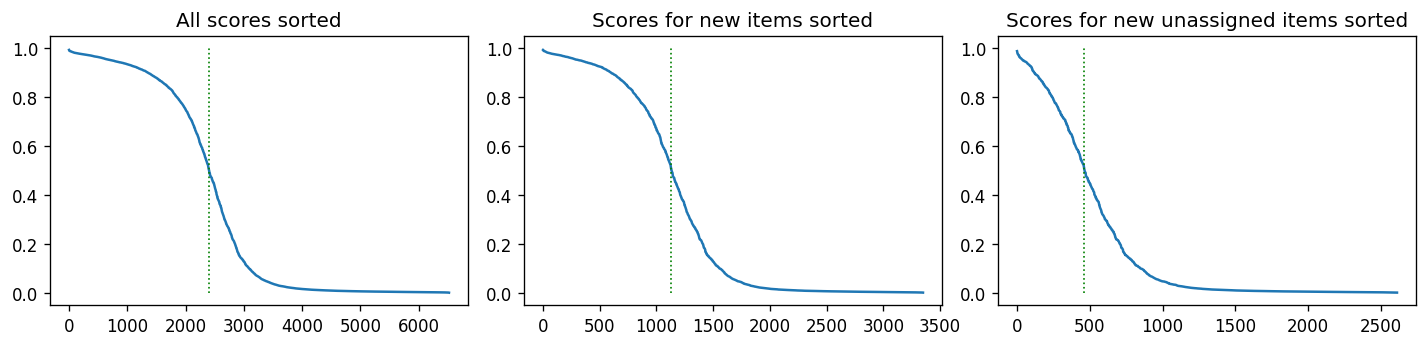

In [48]:
from matplotlib import pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,3), dpi=120)

y = np.array(sorted(df['pred_incl|1'], reverse=True))
x = np.argwhere(y>0.5).max()
ax1.plot(y)
ax1.vlines(x,0,1, colors='green', ls=':', lw=1)
ax1.set_title('All scores sorted')

y = np.array(sorted(df[df['import_upd'] & ~df['import_orig']]['pred_incl|1'], reverse=True))
x = np.argwhere(y>0.5).max()
ax2.plot(y)
ax2.vlines(x,0,1, colors='green', ls=':', lw=1)
ax2.set_title('Scores for new items sorted')

y = np.array(sorted(df[~mask_assigned & mask_glob]['pred_incl|1'], reverse=True))
x = np.argwhere(y>0.5).max()
ax3.plot(y)
ax3.vlines(x, 0, 1, colors='green', ls=':', lw=1)
ax3.set_title('Scores for new unassigned items sorted')

fig.tight_layout()

### Create assignments
Here, we finally create the assignments (and a new assignment scope). This expects that you ran everything in the *Assignment* section of this notebook up to this point. Note, that the database connection might be stale after a long training cycle, so executing this cell might hang. In this case, restart the kernel and execute all *Assignment* cells again.

Note, that there's a security switch `DRY_RUN` in this cell. This prevents you from accidentally creating assignments. You should test this cell with `True` first. When everything looks as expected, run it with `False` and change it right back again.

**Adjust** `title`, `desc`, `LIMIT`, `users`, and if needed the inner loop logic.   
The convention for the title is `[date]_[method]_[query]_[annotators]`

In [49]:
from nacsos_data.models.annotations import AssignmentStatus
from nacsos_data.db.schemas import AssignmentScope, Assignment

DRY_RUN = True

LIMIT = 70
NUM_PER_ITEM = 2

users = [
    ('josefine.hintz', JOSEFINE),
    ('nikola.milojevic', NIKOLA),
    #('felix.creutzig', FELIX),
    #('freda.pachter', FREDA),
]

# sorted newly imported by relevance (highest inclusion first)
srtd = df[~df['import_orig']].sort_values('pred_incl|0')

skip_masks = {'waste'}

with db_engine.session() as session:
    for name, key, mask in masks:
        if key in skip_masks:
            continue

        title = f'20240723_prioritised_{key}_JH_NM'
        desc = f'Top {LIMIT} documents predicted, filtered for the "{name}" query (possibly excluding when higher-ranked ones if seen by other queries)'

        scope_id = str(uuid.uuid4())
        print(f'Creating scope "{title}" with ID {scope_id}')
        if not DRY_RUN:
            scope = AssignmentScope(
                assignment_scope_id=scope_id,
                annotation_scheme_id=SCHEME_ID,
                name=title,
                description=desc
            )
            session.add(scope)
            session.flush()

        scope_mask = srtd.index.isin(df[mask & ~df['import_orig'] & ~df['assigned']].index)

        cnt = 0
        for di, (ri, row) in enumerate(srtd[scope_mask].head(LIMIT).iterrows()):
            item_id = row['item_id']
            
            if not DRY_RUN:
                df.loc[ri, 'assigned'] = True

            print(f'#{di + 1}/{LIMIT} | Creating assignments for {item_id}')

            for ui in range(NUM_PER_ITEM):  # Number of annotators per item
                username, user_id = users[(di + ui) % len(users)]  
                assi_id = uuid.uuid4()
                
                if not DRY_RUN:
                    assi = Assignment(assignment_id=assi_id,
                                      assignment_scope_id=scope_id,
                                      user_id=user_id,
                                      item_id=item_id,
                                      annotation_scheme_id=SCHEME_ID,
                                      status=AssignmentStatus.OPEN,
                                      order=di)
                    session.add(assi)
                    session.flush()
                cnt += 1
                print(f'  -> {username} via {assi_id} for scope {scope_id}')
        print(f'Created {cnt} assignments!')


Creating scope "20240723_prioritised_build_JH_NM" with ID 8c6f5c67-297c-4282-b39f-18dc796dc8f4
#1/70 | Creating assignments for bd2eebaa-6376-4d36-9fe5-c89178edb429
  -> josefine.hintz via cf47e758-7139-4339-88f7-a03a1478425f for scope 8c6f5c67-297c-4282-b39f-18dc796dc8f4
  -> nikola.milojevic via 164890bd-4490-4480-a034-6b8f7a10ffe0 for scope 8c6f5c67-297c-4282-b39f-18dc796dc8f4
#2/70 | Creating assignments for 05f759c8-cfba-4acd-b0c1-4a8ef245de7a
  -> nikola.milojevic via 1e82f2a0-d91f-4bea-a7ed-098d334c14ba for scope 8c6f5c67-297c-4282-b39f-18dc796dc8f4
  -> josefine.hintz via ceca35c3-563b-46ee-832c-b79846f25463 for scope 8c6f5c67-297c-4282-b39f-18dc796dc8f4
#3/70 | Creating assignments for 076d49bd-6920-4a2f-9fed-6820d036f401
  -> josefine.hintz via 5b403e6a-b916-4cab-8dc6-858d749d2528 for scope 8c6f5c67-297c-4282-b39f-18dc796dc8f4
  -> nikola.milojevic via 0a7a0424-8ec2-4141-a64a-520d6c575477 for scope 8c6f5c67-297c-4282-b39f-18dc796dc8f4
#4/70 | Creating assignments for 05c022fe

In [50]:
df['assigned'].sum()

3843

### Storing assignments
We'd like to keep the assignments outside of the platform if we need it again. 

**Adjust** the filename by increasing the counter by 1.

In [51]:
df.to_feather(f'data/screening_round_04_post.arrow')